In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
from helper import get_car_paths, get_cars_df
from efficientnet_pytorch import EfficientNet
import random
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        print(m.weight)
    elif type(m) == nn.BatchNorm1d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [6]:
def get_effnet(name="efficientnet-b0", pretrained=True, n_class=None):
    
    assert n_class != None, "Please specify the number of output classes `n_class`"
    
    if pretrained == True:
        print(f"Getting pretrained {name}")
        m = EfficientNet.from_pretrained(name)
    else:
        print(f"Getting random initialized {name}")
        m = EfficientNet.from_name(name)
    
    n_in = m._fc.in_features
    m._fc = nn.Sequential(
        nn.BatchNorm1d(n_in), 
        nn.Dropout(p=0.5), 
        nn.Linear(n_in, n_class))
    m._fc.apply(init_weights)
    return m

# Download and Untar Data

In [7]:
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')
train_idx, val_idx = train_test_split(train_df.index, test_size=0.2, random_state=42, stratify=train_df["class_name"])

In [8]:
train_df.head()

,fname,class_name,class
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106


# Explore using Fastai Library

In [15]:
tfms = get_transforms()

In [16]:
sz = 300
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=32)

In [17]:
# img_data.normalize(imagenet_stats)

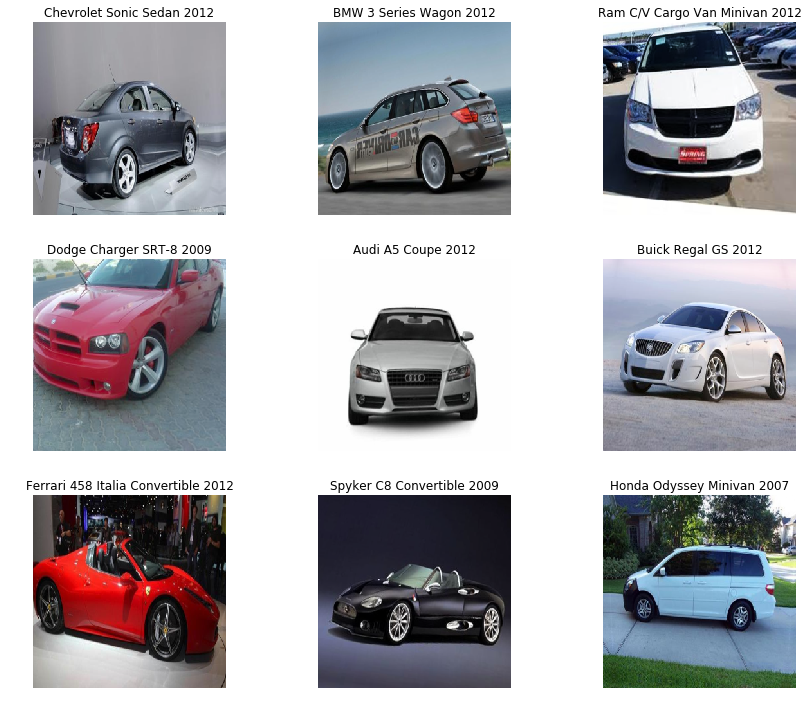

In [15]:
img_data.show_batch(rows=3, figsize=(12,10))

# Efficientnet-b0

In [ ]:
tfms = get_transforms()

In [ ]:
sz = (300,300)
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=32)

In [26]:
eff_net = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [27]:
num_classes = 196
eff_net._fc = nn.Linear(1280, num_classes)
torch.nn.init.kaiming_normal_(eff_net._fc.weight)

Parameter containing:
tensor([[-0.0683, -0.0634, -0.0440,  ..., -0.0524, -0.0407,  0.0377],
        [ 0.0098, -0.0180,  0.0014,  ..., -0.0739, -0.0109,  0.0419],
        [-0.0339, -0.0380,  0.0108,  ..., -0.0569, -0.0163, -0.0190],
        ...,
        [-0.0155,  0.0373,  0.0087,  ..., -0.0442, -0.0300,  0.0224],
        [-0.0744,  0.0108, -0.0604,  ...,  0.0293, -0.0822, -0.0129],
        [ 0.0230, -0.1219,  0.0030,  ...,  0.0382, -0.0683, -0.0983]],
       requires_grad=True)

In [28]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks[0:8]),
            list(eff_net._blocks[8:]) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc]
           ]
learn.split(l_groups)
learn.freeze_to(-1)

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


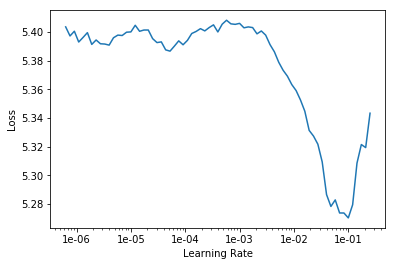

In [30]:
learn.recorder.plot(skip_end=15)

In [ ]:
# acc after 10 epochs = 0.375

In [31]:
learn.fit_one_cycle(6, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.332383,4.514662,0.127150,00:41
1,3.240552,3.702307,0.245700,00:41
2,2.299948,4.649705,0.154791,00:41
3,1.506066,3.489296,0.302211,00:42
4,0.970636,3.370508,0.313268,00:42
5,0.672815,3.350659,0.314496,00:41


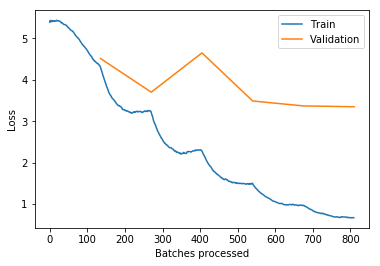

In [33]:
learn.recorder.plot_losses()

In [25]:
learn.save('eff-b0_head_trained')

In [34]:
learn.unfreeze()

In [39]:
learn.lr_find(wd = 1e-5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


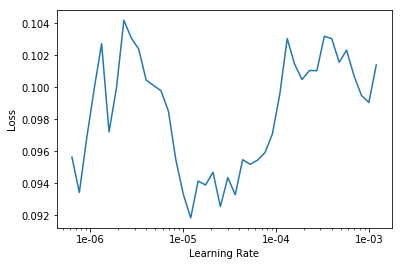

In [40]:
learn.recorder.plot(skip_end=10)

In [41]:
lr = 1e-5
wd = 1e-5
learn.fit_one_cycle(10, slice(lr/100, lr/10, lr), wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.105748,2.334080,0.482801,00:42
1,0.101700,2.330487,0.485872,00:42
2,0.098067,2.331511,0.481572,00:42
3,0.098849,2.330592,0.480958,00:41
4,0.103669,2.332360,0.482187,00:42
5,0.091997,2.333321,0.480344,00:43
6,0.096758,2.330690,0.480958,00:43
7,0.110289,2.331268,0.482801,00:43
8,0.093632,2.330869,0.484644,00:44
9,0.100290,2.327138,0.485872,00:44


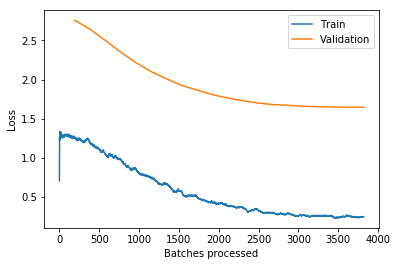

In [30]:
learn.recorder.plot_losses()

In [31]:
lr = 3e-3
learn.fit_one_cycle(20, [lr/100, lr/10, lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.261180,1.632564,0.597666,00:47
1,0.272461,1.656490,0.589681,00:48
2,0.279689,1.630039,0.608108,00:47
3,0.306101,1.773577,0.577396,00:47
4,0.328519,1.778671,0.583538,00:48
5,0.305478,1.736057,0.607494,00:47
6,0.242348,1.661483,0.621622,00:46
7,0.189739,1.654706,0.648034,00:47
8,0.158837,1.580598,0.653563,00:48
9,0.129406,1.541423,0.662776,00:47


In [34]:
learn.save("eff-b0_finetuned1")

# EfficientNet-b3

In [16]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')


Loaded pretrained weights for efficientnet-b3


In [17]:
num_classes = 196
eff_net._fc = nn.Linear(1536, num_classes)
torch.nn.init.kaiming_normal_(eff_net._fc.weight)

Parameter containing:
tensor([[-0.0409, -0.0396, -0.1206,  ...,  0.0080, -0.0235,  0.0122],
        [-0.0178,  0.0679,  0.0312,  ...,  0.0542,  0.0063, -0.0121],
        [ 0.0511,  0.0350, -0.0332,  ..., -0.0294, -0.0250,  0.0715],
        ...,
        [-0.0062, -0.0346, -0.0064,  ..., -0.0312,  0.0328, -0.0383],
        [-0.0233,  0.0038,  0.0435,  ...,  0.0274,  0.0133,  0.0035],
        [-0.0154,  0.0529, -0.0209,  ...,  0.0391, -0.0223,  0.0117]],
       requires_grad=True)

In [18]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks[0:13]),
            list(eff_net._blocks[13:]) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc]
           ]
learn.split(l_groups)
learn.freeze_to(-1)

In [19]:
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Chevrolet Traverse SUV 2012,Buick Verano Sedan 2012
Path: Data/resized_sz/320/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Hyundai Tucson SUV 2012,Dodge Dakota Club Cab 2007,Chevrolet Silverado 1500 Classic Extended Cab 2007,Lincoln Town Car Sedan 2011,Lamborghini Reventon Coupe 2008
Path: Data/resized_sz/320/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_de

In [20]:
learn.lr_find(wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


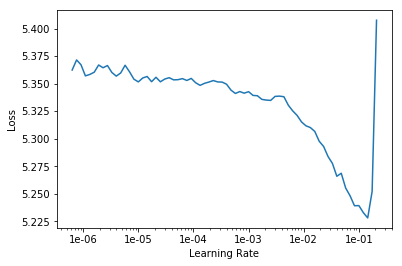

In [21]:
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy,time
0,4.158328,3.677619,0.188575,01:02
1,3.788074,3.925518,0.200860,01:01
2,3.251094,3.641747,0.244472,01:02
3,2.514037,3.292651,0.282555,01:02
4,1.896273,2.920882,0.329853,01:02
5,1.437702,2.832627,0.361794,01:02


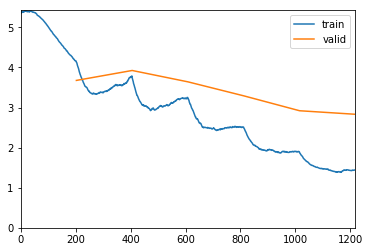

In [22]:
lr = 2e-2
wd = 1e-1
learn.fit_one_cycle(6, max_lr=lr, wd=wd)

In [23]:
learn.save("eff-b3_head_trained")

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


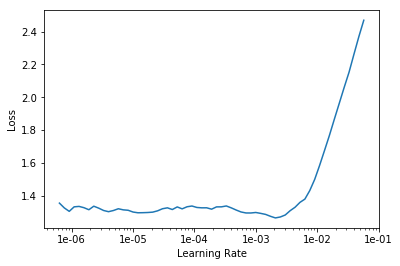

In [25]:
learn.lr_find(wd=1e-1)
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.938280,1.751602,0.549754,01:30
1,0.855861,1.945343,0.539312,01:31
2,0.783570,1.881433,0.533170,01:28
3,0.515423,1.434328,0.656634,01:29
4,0.351104,1.334360,0.652334,01:30
5,0.170032,0.985327,0.740786,01:31
6,0.070574,0.774052,0.803440,01:30
7,0.033975,0.640989,0.832924,01:28
8,0.020159,0.624872,0.843980,01:28
9,0.012580,0.615840,0.843980,01:32


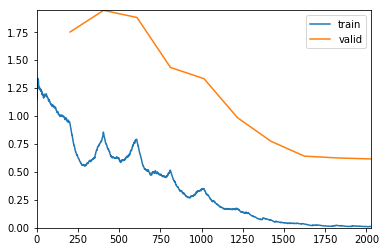

In [26]:
lr = 1e-3
wd = 1e-1
learn.fit_one_cycle(10, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.022424,0.673734,0.829853,01:32
1,0.139297,1.263816,0.714373,01:31
2,0.277628,1.287474,0.704545,01:32
3,0.202155,1.070590,0.747543,01:33
4,0.167610,1.020637,0.773342,01:36
5,0.084551,0.846152,0.797297,01:31
6,0.046883,0.680464,0.840295,01:31
7,0.020910,0.631352,0.855651,01:32
8,0.011123,0.610833,0.858722,01:35
9,0.009153,0.603746,0.864865,01:34


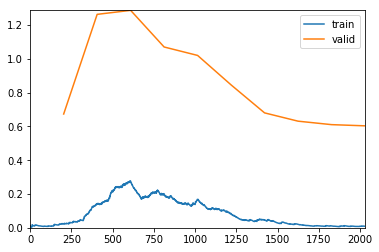

In [27]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(10, max_lr=slice(lr/10,lr), wd=wd)

In [28]:
learn.save("eff-b3_ft-1")

epoch,train_loss,valid_loss,accuracy,time
0,0.006444,0.602125,0.864251,01:31
1,0.006575,0.596557,0.867322,01:28
2,0.005213,0.589340,0.868550,01:29
3,0.005916,0.583566,0.867936,01:29
4,0.005591,0.579668,0.867936,01:29
5,0.004608,0.577742,0.866708,01:29
6,0.004126,0.574640,0.867936,01:29
7,0.003907,0.574353,0.871622,01:31
8,0.004420,0.573177,0.870393,01:28
9,0.003721,0.573230,0.870393,01:31


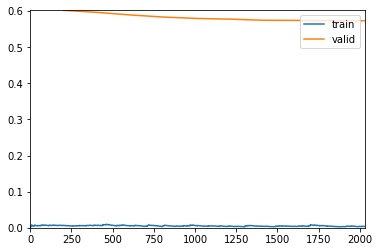

In [30]:
lr = 1e-4
wd = 1e-1
learn.fit_one_cycle(10, max_lr=slice(lr/100,lr), wd=wd)

In [31]:
learn.save("eff-b3_ft-2")

In [35]:
test_data = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0, bs=32)

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f8623700b38>, device=device(type='cuda', index=0), tfms=[], collate_fn=<function data_collate at 0x7f862ea83c80>)

In [38]:
learn.to_fp32().validate(test_data.train_dl)

[0.5611969, tensor(0.8751)]

# Other Databunch

In [19]:
tfms = get_transforms(
    do_flip = True,
    flip_vert = False,
    max_rotate = 10.0,
    max_zoom = 1.1,
    max_lighting = 0.2,
    max_warp = 0.2,
    p_affine = 0.75,
    p_lighting = 0.75,
#     xtra_tfms = rand_resize_crop(size=224, max_scale=0.8)
)
sz = 300
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=32)

In [20]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')
num_classes = 196
eff_net._fc = nn.Linear(1536, num_classes)
torch.nn.init.kaiming_normal_(eff_net._fc.weight)

Loaded pretrained weights for efficientnet-b3


Parameter containing:
tensor([[ 0.0275, -0.0126,  0.0131,  ..., -0.0755, -0.0079, -0.0277],
        [ 0.0289, -0.0154,  0.0222,  ..., -0.0361,  0.0332,  0.0194],
        [-0.0164,  0.0303, -0.0437,  ..., -0.0371, -0.0173, -0.0086],
        ...,
        [-0.0051,  0.0479,  0.0131,  ..., -0.0441,  0.0310, -0.0117],
        [ 0.0029, -0.0125, -0.0026,  ..., -0.0266,  0.0206, -0.0360],
        [-0.0325, -0.0266,  0.0661,  ...,  0.0539,  0.0297,  0.0278]],
       requires_grad=True)

In [21]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)

In [17]:

l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks[0:13]),
            list(eff_net._blocks[13:]) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc]
           ]
learn.split(l_groups)
learn.freeze_to(-1)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Dodge Charger Sedan 2012
Path: Data/resized_sz/320/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
GMC Savana Van 2012,Chevrolet TrailBlazer SS 2009,Honda Accord Coupe 2012,Audi A5 Coupe 2012,Jeep Compass SUV 2012
Path: Data/resized_sz/320/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


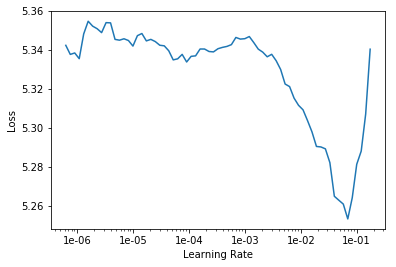

In [44]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy,time
0,4.500048,4.018613,0.174447,01:02
1,3.366377,3.319551,0.275184,01:03
2,2.793204,3.101268,0.305897,01:03
3,2.292270,2.965024,0.335995,01:03
4,1.831445,2.828581,0.364865,01:03
5,1.535093,2.803460,0.366093,01:02


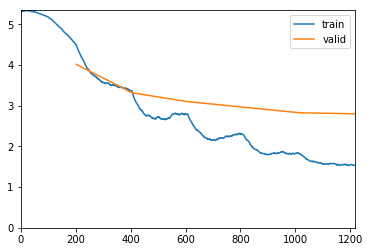

In [45]:
lr = 1e-2
wd = 1e-1
learn.fit_one_cycle(6, max_lr=lr, wd=wd)

In [46]:
# learn.save("eff-b3_regular_resize_head_trained")

In [18]:
learn.load("eff-b3_regular_resize_head_trained")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Dodge Charger Sedan 2012
Path: Data/resized_sz/320/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
GMC Savana Van 2012,Chevrolet TrailBlazer SS 2009,Honda Accord Coupe 2012,Audi A5 Coupe 2012,Jeep Compass SUV 2012
Path: Data/resized_sz/320/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel

In [19]:
learn.unfreeze()

In [20]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2dSamePadding    [40, 150, 150]       1,080      True      
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
Conv2dSamePadding    [40, 150, 150]       360        True      
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
Conv2dSamePadding    [10, 1, 1]           410        True      
______________________________________________________________________
Conv2dSamePadding    [40, 1, 1]           440        True      
______________________________________________________________________
Conv2dSamePadding    [24, 150, 150]       960        True      
______________________________________________________________

epoch,train_loss,valid_loss,accuracy,time
0,1.533815,0.940368,0.792998,01:29
1,1.040228,0.768620,0.813268,01:30
2,0.607358,0.866368,0.765971,01:30
3,0.351798,0.837606,0.762899,01:30
4,0.214080,0.822697,0.785627,01:29
5,0.125380,0.724702,0.808354,01:30
6,0.080262,0.691637,0.820025,01:31
7,0.049162,0.665653,0.832310,01:31
8,0.026303,0.647182,0.835995,01:32
9,0.021239,0.643478,0.839066,01:30


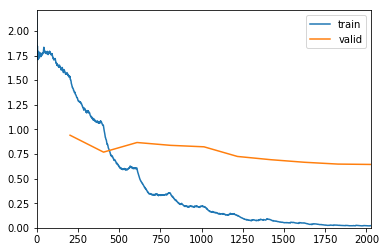

In [21]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(10, max_lr=slice(lr/100, lr), wd=wd)

In [22]:
learn.save("eff-b3_regular_resize_ft-1")

# Use Dropout in head

In [13]:
tfms = get_transforms(
    do_flip = True,
    flip_vert = False,
    max_rotate = 10.0,
    max_zoom = 1.1,
    max_lighting = 0.2,
    max_warp = 0.2,
    p_affine = 0.75,
    p_lighting = 0.75,
#     xtra_tfms = rand_resize_crop(size=224, max_scale=0.8)
)
sz = 300
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=32)

In [14]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')
num_classes = 196
num_in = 1536
eff_net._fc = nn.Sequential(
    nn.BatchNorm1d(num_in), 
    nn.Dropout(p=0.5), 
    nn.Linear(num_in, num_classes))
# torch.nn.init.kaiming_normal_(eff_net._fc.weight)


Loaded pretrained weights for efficientnet-b3


In [15]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.freeze_to(-1)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/resized_sz/320/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
GMC Acadia SUV 2012,Buick Regal GS 2012,Cadillac Escalade EXT Crew Cab 2007,Mercedes-Benz E-Class Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/resized_sz/320/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_c

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


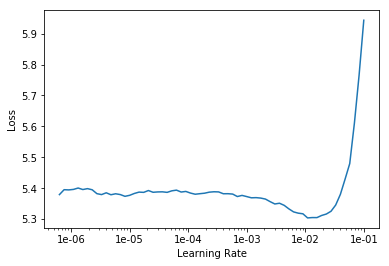

In [16]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy,time
0,4.086313,3.876972,0.155405,01:29
1,3.282426,5.822524,0.122236,01:30
2,2.288225,3.047067,0.320639,01:29
3,1.373469,1.509957,0.625307,01:29
4,0.700507,0.804129,0.777027,01:29
5,0.411228,0.578364,0.840295,01:29


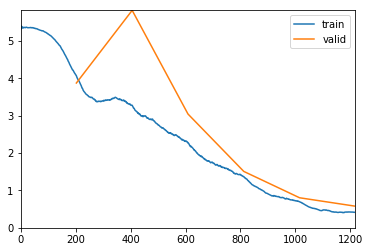

In [17]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(6, max_lr=lr, wd=wd)

In [18]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2dSamePadding    [40, 150, 150]       1,080      True      
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
Conv2dSamePadding    [40, 150, 150]       360        True      
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
Conv2dSamePadding    [10, 1, 1]           410        True      
______________________________________________________________________
Conv2dSamePadding    [40, 1, 1]           440        True      
______________________________________________________________________
Conv2dSamePadding    [24, 150, 150]       960        True      
______________________________________________________________

epoch,train_loss,valid_loss,accuracy,time
0,0.352973,0.559186,0.847666,01:29
1,0.458321,0.724893,0.802826,01:31
2,0.506879,0.952661,0.743243,01:33
3,0.488702,0.893035,0.769042,01:29
4,0.379611,0.753773,0.797912,01:29
5,0.243680,0.688957,0.821867,01:34
6,0.170611,0.530344,0.861794,01:36
7,0.099128,0.507312,0.869779,01:33
8,0.073821,0.484467,0.877150,01:30
9,0.061396,0.475960,0.878993,01:32


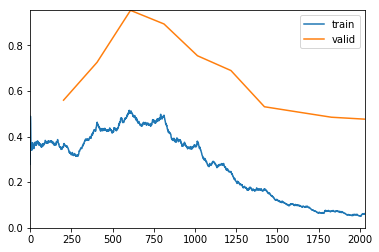

In [19]:
lr = 1e-3
wd = 1e-1
learn.fit_one_cycle(10, max_lr=lr, wd=wd)

In [20]:
learn.save("b3_noft-1")

epoch,train_loss,valid_loss,accuracy,time
0,0.056250,0.474842,0.876536,01:32
1,0.051610,0.473464,0.877764,01:32
2,0.056756,0.490874,0.877764,01:33
3,0.050655,0.489709,0.874693,01:32
4,0.043004,0.482520,0.874693,01:31
5,0.042489,0.486383,0.882678,01:32
6,0.036550,0.486947,0.882064,01:33
7,0.036962,0.483449,0.882064,01:31
8,0.029143,0.482211,0.882678,01:32
9,0.022973,0.481944,0.882064,01:31


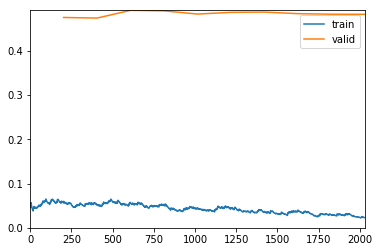

In [24]:
lr = 1e-4
wd = 1e-1
learn.fit_one_cycle(10, max_lr=lr, wd=wd)

# 60 Epochs

In [11]:
tfms = get_transforms()
sz = 300
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=32)

In [7]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')
num_classes = 196
num_in = 1536
eff_net._fc = nn.Sequential(
    nn.BatchNorm1d(num_in), 
    nn.Dropout(p=0.5), 
    nn.Linear(num_in, num_classes))
# torch.nn.init.kaiming_normal_(eff_net._fc.weight)


Loaded pretrained weights for efficientnet-b3


In [8]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.freeze_to(-1)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Honda Accord Sedan 2012,Dodge Durango SUV 2012,Chevrolet Avalanche Crew Cab 2012,Nissan 240SX Coupe 1998,Audi S4 Sedan 2007
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3),

In [9]:
# lr = 3e-3
# wd = 1e-1
# acc = .895

epoch,train_loss,valid_loss,accuracy,time
0,5.089567,4.823735,0.100737,01:34
1,4.122067,3.661832,0.310811,01:32
2,2.656883,2.145030,0.601351,01:32
3,1.346899,1.178109,0.721744,01:33
4,0.726477,0.949073,0.744472,01:32
5,0.676155,1.250909,0.665233,01:32
6,0.725841,1.366459,0.665233,01:33
7,0.864575,1.711966,0.600123,01:33
8,0.985913,1.753116,0.578010,01:33
9,1.033766,2.115015,0.528870,01:33


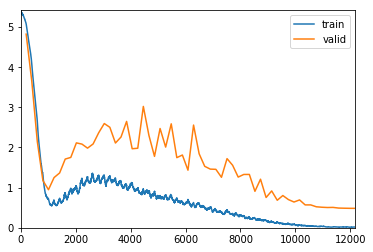

In [20]:
# lr = 3e-3
# wd = 1e-1
# learn.fit_one_cycle(60, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,5.103193,4.896840,0.086609,01:36
1,4.149298,3.765590,0.286241,01:37
2,2.722309,2.133015,0.578624,01:36
3,1.389944,1.180246,0.732187,01:36
4,0.761025,1.034611,0.734029,01:39
5,0.718119,1.369077,0.649263,01:34
6,0.759857,1.408394,0.643120,01:35
7,0.812203,1.482635,0.626536,01:35
8,1.008081,1.563376,0.640049,01:36
9,1.072235,1.974433,0.565725,01:35


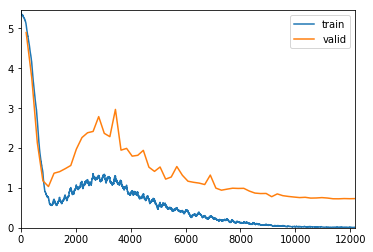

In [10]:
lr = 3e-3
wd = 1e-5
learn.fit_one_cycle(60, max_lr=lr, wd=wd)

In [11]:
learn.save("b3-60ep")

epoch,train_loss,valid_loss,accuracy,time
0,0.020504,0.735219,0.893120,01:33
1,0.010363,0.736130,0.890049,01:34
2,0.019205,0.735449,0.888821,01:34
3,0.025829,0.730320,0.890663,01:34
4,0.017718,0.741014,0.894963,01:33
5,0.014877,0.754630,0.893120,01:34
6,0.015602,0.738310,0.896192,01:34
7,0.009410,0.736345,0.894963,01:34
8,0.016380,0.730752,0.896192,01:34
9,0.017487,0.727488,0.896192,01:35


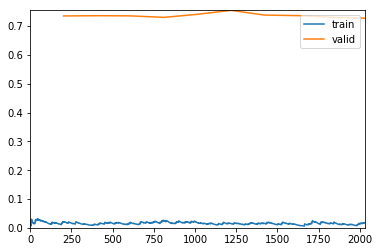

In [12]:
lr = 3e-4
wd = 1e-3
learn.fit_one_cycle(10, max_lr=lr, wd=wd)

In [13]:
learn.save("b3-60ep-2")

epoch,train_loss,valid_loss,accuracy,time
0,0.016432,0.729542,0.895577,01:33
1,0.009826,0.727352,0.898034,01:33
2,0.011102,0.722604,0.896806,01:34
3,0.016933,0.723701,0.896806,01:34
4,0.010893,0.727109,0.898034,01:34
5,0.009808,0.727224,0.896806,01:33
6,0.011162,0.730787,0.897420,01:34
7,0.008958,0.735160,0.896192,01:34
8,0.007732,0.732877,0.898649,01:34
9,0.009478,0.731315,0.898034,01:34


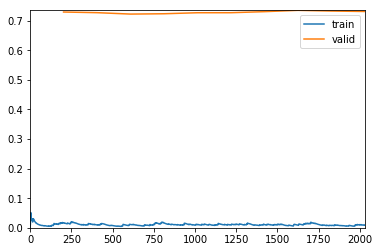

In [14]:
lr = 3e-5
wd = 1e-3
learn.fit(10, lr, wd=wd)

In [15]:
learn.save("b3-60ep-3")

# From Scratch

In [8]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)

In [9]:
eff_net = EfficientNet.from_name('efficientnet-b3')
num_classes = 196
num_in = 1536
eff_net._fc = nn.Sequential(
    nn.BatchNorm1d(num_in), 
    nn.Dropout(p=0.5), 
    nn.Linear(num_in, num_classes))


In [10]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)

l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc],
           ]
learn.split(l_groups)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


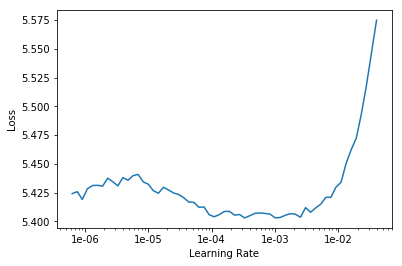

In [14]:
learn.recorder.plot(skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,5.334187,5.281078,0.001843,01:35
1,5.232797,5.295763,0.003686,01:35
2,5.197654,5.954601,0.003686,01:36
3,5.155608,7.378270,0.009828,01:35
4,5.152655,7.455806,0.011057,01:36
5,5.123503,12.592406,0.011671,01:36
6,5.136282,12.033265,0.009828,01:36
7,5.049624,27.560949,0.007985,01:36
8,5.020684,13.836268,0.007371,01:36
9,5.015241,13.020582,0.009214,01:36


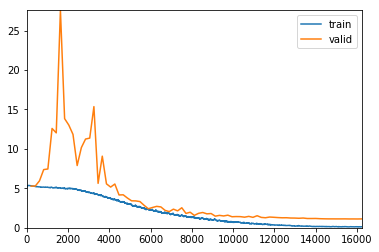

In [15]:
lr = 3e-3
wd = 1e-3
learn.fit_one_cycle(80, max_lr=lr, wd=wd)

In [16]:
learn.save("b3_scratch_ep80")

epoch,train_loss,valid_loss,accuracy,time
0,0.137373,1.128861,0.760442,01:35
1,0.140664,1.124450,0.759214,01:35
2,0.121901,1.131353,0.757371,01:35
3,0.128507,1.122818,0.756757,01:35
4,0.124865,1.126197,0.761671,01:34
5,0.127246,1.132880,0.754914,01:34
6,0.141722,1.138541,0.758600,01:35
7,0.137238,1.158538,0.745700,01:35
8,0.131528,1.147489,0.756757,01:35
9,0.148513,1.185261,0.757371,01:35


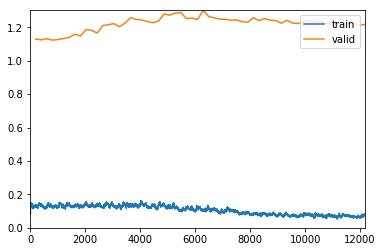

In [17]:
lr = 3e-4
wd = 1e-3
learn.fit_one_cycle(60, max_lr=lr, wd=wd)

In [18]:
learn.save("b3_scratch_ep80+60")

# LR

In [10]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = (ImageList.from_df(train_df, train_path)
        .split_by_idx(val_idx)
        .label_from_df()
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [9]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)

In [11]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')
num_classes = 196
num_in = 1536
eff_net._fc = nn.Sequential(
    nn.BatchNorm1d(num_in), 
    nn.Dropout(p=0.5), 
    nn.Linear(num_in, num_classes))
eff_net._fc.apply(init_weights)

Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0304,  0.0011,  0.0122,  ...,  0.0159,  0.0152,  0.0264],
        [ 0.0080,  0.0439, -0.0775,  ...,  0.0278,  0.0431,  0.0130],
        [-0.0465,  0.0422,  0.0027,  ..., -0.0994,  0.0193, -0.0644],
        ...,
        [ 0.0301, -0.0035,  0.0406,  ..., -0.0554, -0.0111, -0.0001],
        [ 0.0552, -0.0297,  0.0202,  ...,  0.0164, -0.0217,  0.0307],
        [ 0.0339,  0.0469,  0.0469,  ...,  0.0538, -0.0446, -0.0170]],
       requires_grad=True)


Sequential(
  (0): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=1536, out_features=196, bias=True)
)

In [12]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)

l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc],
           ]
learn.split(l_groups)
learn = learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


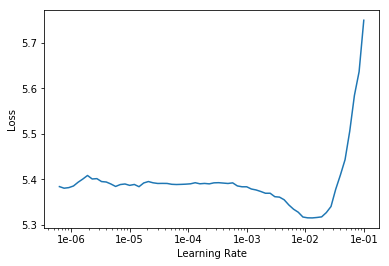

In [90]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy,time
0,4.347986,6.682806,0.027624,01:35
1,4.424758,8.998511,0.023327,01:36
2,3.238699,5.228230,0.152241,01:35
3,2.038701,1.677991,0.545734,01:35
4,1.196411,0.834688,0.765500,01:36
5,0.777141,0.684011,0.801719,01:35


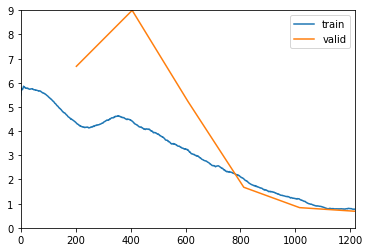

In [13]:
lr = 5e-3
wd = 1e-3
learn.fit_one_cycle(6, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.684959,0.660761,0.817680,01:35
1,0.645906,0.638639,0.821977,01:35
2,0.594607,0.617076,0.823818,01:35
3,0.561482,0.601192,0.832413,01:35
4,0.485929,0.598889,0.834868,01:35
5,0.475739,0.619454,0.823818,01:35
6,0.427991,0.620117,0.820749,01:36
7,0.389768,0.687635,0.817680,01:35
8,0.389816,0.693949,0.810927,01:35
9,0.372659,0.713323,0.803560,01:35


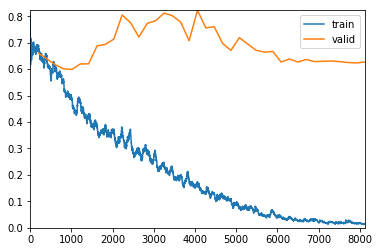

In [14]:
lr = 1e-3
wd = 1e-3
learn.fit_one_cycle(40, max_lr=lr, wd=wd)

In [15]:
learn.save("b3_strat_split_ft-1")

# All Train Data

In [12]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [13]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')
num_classes = 196
num_in = 1536
eff_net._fc = nn.Sequential(
    nn.BatchNorm1d(num_in), 
    nn.Dropout(p=0.5), 
    nn.Linear(num_in, num_classes))
eff_net._fc.apply(init_weights)

Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0263, -0.0072,  0.0349,  ...,  0.0339, -0.0028,  0.0054],
        [ 0.0358,  0.0401,  0.0232,  ..., -0.0363, -0.0490,  0.0060],
        [ 0.0220, -0.0262,  0.0160,  ..., -0.0163,  0.0629,  0.0593],
        ...,
        [-0.0331, -0.0213,  0.0344,  ..., -0.0433,  0.0303,  0.0325],
        [-0.0015,  0.0062, -0.0100,  ..., -0.0469,  0.0123, -0.0473],
        [ 0.0289, -0.0325,  0.0089,  ...,  0.0136,  0.0396, -0.0213]],
       requires_grad=True)


Sequential(
  (0): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=1536, out_features=196, bias=True)
)

In [14]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)

l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc],
           ]
learn.split(l_groups)
learn = learn.to_fp16()

In [13]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(60, max_lr=lr, wd=wd)

In [14]:
learn.save("b3-all_train")

In [15]:
learn.load("b3-all_train")

Learner(data=ImageDataBunch;

Train: LabelList (8144 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False)
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dSamePadding(40, 10, kernel_size=(1, 1), stride=(1

In [16]:
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs*2)

In [18]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.4392778, tensor(0.8976)]

# 40 Epoch

In [11]:
learn.destroy()
del learn
gc.collect()


NameError: name 'learn' is not defined

In [12]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)

In [13]:
eff_net = EfficientNet.from_pretrained('efficientnet-b3')
num_classes = 196
num_in = 1536
eff_net._fc = nn.Sequential(
    nn.BatchNorm1d(num_in), 
    nn.Dropout(p=0.5), 
    nn.Linear(num_in, num_classes))
eff_net._fc.apply(init_weights)


Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0346,  0.0976,  0.0473,  ...,  0.0109, -0.0223,  0.0406],
        [ 0.0630,  0.0063, -0.0467,  ..., -0.0256, -0.0023, -0.0591],
        [-0.0170,  0.0337,  0.0493,  ...,  0.0352,  0.0579, -0.0205],
        ...,
        [-0.0029,  0.0120,  0.0245,  ...,  0.0133,  0.0569,  0.0420],
        [ 0.0092,  0.0068,  0.0215,  ..., -0.0460, -0.0333,  0.0017],
        [ 0.0025, -0.0113,  0.0366,  ...,  0.0695,  0.0297,  0.0306]],
       requires_grad=True)


Sequential(
  (0): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=1536, out_features=196, bias=True)
)

In [14]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc],
           ]
learn.split(l_groups)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,6.219718,4.664832,0.078624,01:35
1,4.156107,2.851302,0.347052,01:35
2,2.353379,1.676801,0.566339,01:35
3,1.557491,1.530643,0.598894,01:35
4,1.496809,1.839232,0.540541,01:34
5,1.593167,3.283624,0.361179,01:35
6,1.768250,3.116432,0.386978,01:34
7,1.843321,3.313660,0.377150,01:35
8,1.866791,3.313007,0.382678,01:35
9,1.911362,2.966665,0.374693,01:35


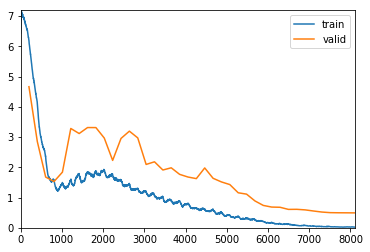

In [19]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(40, max_lr=lr, wd=wd)

In [20]:
# learn.save("b3-40epoch")

In [15]:
learn.load("b3-40epoch")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

In [18]:
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs*2)

In [19]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.48082003, tensor(0.8821)]

epoch,train_loss,valid_loss,accuracy,time
0,0.116265,1.096518,0.731573,01:36
1,0.181059,0.816172,0.811425,01:37
2,0.093555,0.687198,0.843980,01:37
3,0.056677,0.507484,0.882064,01:40
4,0.040587,0.492904,0.888821,01:39


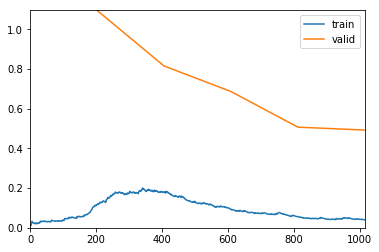

In [16]:
lr = 1e-3
wd = 1e-1
learn.fit_one_cycle(5, max_lr=lr, pct_start=0.2, final_div=1000, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.035757,0.505295,0.886978,01:37
1,0.029753,0.498427,0.886364,01:36
2,0.031774,0.484654,0.891892,01:37
3,0.024523,0.482983,0.891892,01:39
4,0.022545,0.481622,0.891892,01:38


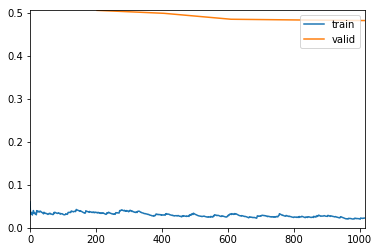

In [17]:
lr = 1e-4
wd = 1e-1
learn.fit_one_cycle(5, max_lr=lr, pct_start=0.2, final_div=1000, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.020620,0.479215,0.892506,01:36
1,0.024834,0.481713,0.890663,01:35
2,0.026809,0.481005,0.892506,01:37
3,0.030421,0.480749,0.891278,01:38
4,0.024531,0.480991,0.890663,01:36


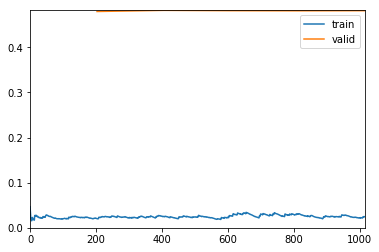

In [18]:
lr = 1e-5
wd = 1e-1
learn.fit_one_cycle(5, max_lr=lr, pct_start=0.2, final_div=1000, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.022701,0.481864,0.891892,01:36
1,0.019150,0.477795,0.892506,01:38
2,0.024004,0.477208,0.893735,01:37
3,0.025233,0.478394,0.893735,01:36
4,0.022136,0.477635,0.890663,01:35


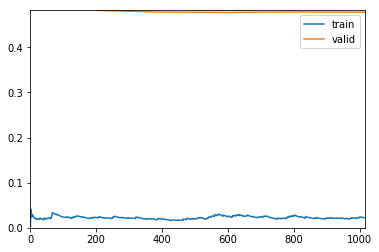

In [19]:
lr = 1e-5
wd = 1e-1
learn.fit_one_cycle(5, lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.020970,0.477850,0.892506,01:37
1,0.018006,0.480240,0.893120,01:35
2,0.028175,0.479842,0.893120,01:36
3,0.018747,0.478095,0.893735,01:38
4,0.021988,0.477764,0.893120,01:35


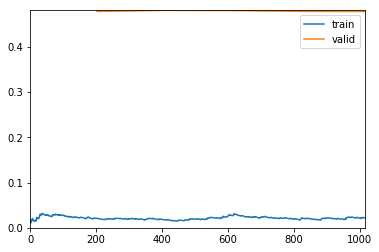

In [20]:
lr = 1e-5
wd = 1e-5
learn.fit_one_cycle(5, lr, wd=wd)

In [21]:
learn.save("b3-40epoch+20")

# AA

In [12]:
learn.destroy()
del learn
gc.collect()


this Learner object self-destroyed - it still exists, but no longer usable


9

In [13]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)

In [14]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0675, -0.0408,  0.0657,  ..., -0.0139, -0.0700,  0.0628],
        [-0.0261,  0.0411,  0.0292,  ..., -0.0297, -0.0726, -0.0069],
        [-0.0234,  0.0145, -0.0147,  ..., -0.0439,  0.0140,  0.0168],
        ...,
        [ 0.0470,  0.0196, -0.0131,  ...,  0.0576, -0.0153, -0.0522],
        [ 0.0695,  0.0170, -0.0078,  ..., -0.0122,  0.0138, -0.0233],
        [ 0.0426,  0.0035, -0.0074,  ..., -0.0556, -0.0468,  0.0363]],
       requires_grad=True)


In [15]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.mixup().to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Dodge Journey SUV 2012,Dodge Charger Sedan 2012,Chevrolet Traverse SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Toyota 4Runner SUV 2012,Ferrari 458 Italia Convertible 2012,Cadillac Escalade EXT Crew Cab 2007,Cadillac CTS-V Sedan 2012,Buick Regal GS 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3

epoch,train_loss,valid_loss,accuracy,time
0,6.367083,4.900486,0.060197,01:35
1,4.711191,3.247443,0.272727,01:38
2,4.026114,3.508020,0.272727,01:37
3,4.172791,6.662920,0.124079,01:38
4,3.929240,3.465227,0.249386,01:41
5,3.789744,3.364387,0.242629,01:37
6,3.353858,2.986276,0.323096,01:36
7,3.009555,2.418250,0.437961,01:36
8,2.757039,2.314776,0.486486,01:36
9,2.577063,2.008363,0.522113,01:36


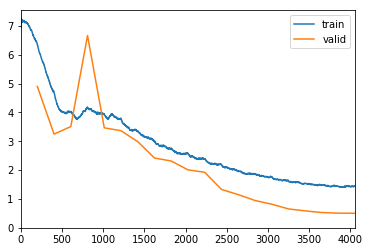

In [16]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(20, max_lr=lr, wd=wd)

In [17]:
learn.save("b3_mixup-1")

# No Mixup 20 Epoch

In [18]:
learn.destroy()
del learn
gc.collect()


this Learner object self-destroyed - it still exists, but no longer usable


0

In [19]:
tfms = get_transforms()
sz = 300
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)

In [20]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0326, -0.0098, -0.0680,  ..., -0.0592,  0.0206, -0.0440],
        [ 0.0341, -0.0018, -0.0460,  ...,  0.0683, -0.0240, -0.0008],
        [-0.0592, -0.0446, -0.0072,  ..., -0.0015, -0.0260, -0.0271],
        ...,
        [-0.0407,  0.0006,  0.0063,  ...,  0.0645,  0.0544,  0.0049],
        [-0.0095, -0.0126, -0.0006,  ...,  0.0332, -0.0049, -0.0804],
        [-0.0035, -0.0227, -0.0495,  ..., -0.0436, -0.0256,  0.0154]],
       requires_grad=True)


In [21]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
BMW X6 SUV 2012,BMW X6 SUV 2012,Bentley Continental Flying Spur Sedan 2007,Spyker C8 Convertible 2009,Acura RL Sedan 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=

epoch,train_loss,valid_loss,accuracy,time
0,6.045254,4.463654,0.093980,01:35
1,3.373480,2.537371,0.388821,01:35
2,2.314806,2.945903,0.413391,01:35
3,2.543535,3.639074,0.284398,01:36
4,2.757313,3.993563,0.298526,01:35
5,2.507454,3.144600,0.309582,01:36
6,2.060047,2.248975,0.464988,01:36
7,1.879382,2.487857,0.398649,01:36
8,1.456941,2.103288,0.492629,01:35
9,1.213674,1.763182,0.563268,01:36


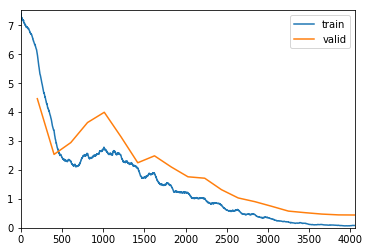

In [22]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(20, max_lr=lr, wd=wd)

In [23]:
learn.save("b3_20epoch-1")

epoch,train_loss,valid_loss,accuracy,time
0,0.070316,0.444957,0.895577,01:36
1,0.078084,0.458633,0.892506,01:38
2,0.086598,0.475001,0.877150,01:37
3,0.080879,0.506519,0.878378,01:36
4,0.079183,0.508436,0.882678,01:39
5,0.072260,0.470224,0.883292,01:37
6,0.060576,0.465499,0.894349,01:39
7,0.041676,0.460775,0.896806,01:40
8,0.034160,0.456281,0.895577,01:39
9,0.036605,0.454257,0.896192,01:40


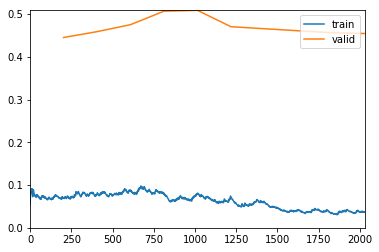

In [24]:
lr = 3e-4
wd = 1e-1
learn.fit_one_cycle(10, max_lr=lr, wd=wd)

In [25]:
learn.save("b3_20epoch+10-2")

# Squish Resize

In [39]:
learn.destroy()
del learn
gc.collect()


this Learner object self-destroyed - it still exists, but no longer usable


0

In [40]:
tfms = get_transforms()
sz = (300, 300)
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)

In [43]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0281, -0.0019,  0.0115,  ..., -0.0440, -0.0237,  0.0328],
        [-0.0701, -0.0136, -0.0592,  ...,  0.0717,  0.0204, -0.0701],
        [-0.0068,  0.1005,  0.0342,  ..., -0.0862, -0.0272,  0.0372],
        ...,
        [-0.0125, -0.0365,  0.0380,  ...,  0.0299, -0.0102, -0.0193],
        [-0.0336, -0.0560,  0.0413,  ..., -0.0357, -0.0576, -0.0055],
        [-0.0309, -0.0500,  0.0342,  ...,  0.0023, -0.0601,  0.0098]],
       requires_grad=True)


In [44]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Dodge Journey SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Chevrolet Malibu Sedan 2007,Audi S4 Sedan 2007,Infiniti QX56 SUV 2011,Hyundai Azera Sedan 2012,Chevrolet Camaro Convertible 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.811231,4.097666,0.141278,01:34
1,2.982894,2.255915,0.441646,01:34
2,2.100383,3.412209,0.302211,01:35
3,2.330353,4.630439,0.251843,01:34
4,2.604250,3.610461,0.280098,01:35
5,2.226320,3.511216,0.316953,01:35
6,1.804191,2.753786,0.345823,01:35
7,1.549003,2.958639,0.337224,01:35
8,1.342802,2.727281,0.376536,01:35
9,0.984336,1.773456,0.558354,01:35


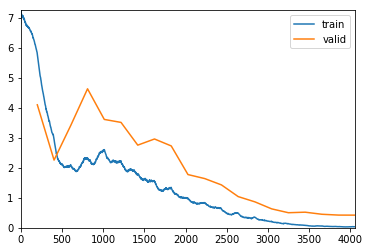

In [45]:
lr = 3e-3
wd = 1e-1
learn.fit_one_cycle(20, max_lr=lr, wd=wd)

In [47]:
learn.save("b3_300x300-1")

In [48]:
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs*2)

In [51]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.4088275, tensor(0.8975)]

# fin